# Identifying Hate Speech with BERT and CNN

Two years ago, [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview) was published on Kaggle.
The main aim of the competition was to develop tools that would help to improve online conversation:

<em>Discussing things you care about can be difficult. 
    The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. 
Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.</em>

In this post, we develop a tool that is able to recognize toxicity in comments.
We use BERT (a Bidirectional Encoder Representations from Transformers) to transform comments to word embeddings.
With embeddings, we train a Convolutional Neural Network (CNN) using PyTorch that is able to identify hate speech.

## Setup

In [1]:
%matplotlib inline

In [62]:
import logging
import time
from platform import python_version

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable

In [35]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("torch==%s" % torch.__version__)
print("sklearn==%s" % sklearn.__version__)
print("transformers==%s" % transformers.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.7.3
pandas==0.25.3
numpy==1.17.4
torch==1.3.1
sklearn==0.21.0
transformers==2.1.1
matplotlib==3.0.3


In [4]:
# Suppress a warning with comments that have more than 512 words - the upper limit for BERT
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

## Loading the data

Go to [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview) to download the data (unzip it and rename the folder to `data`).
We train and test the model with `train.csv` because entries in `test.csv` are without labels and are intended for Kaggle submissions.

Let's load the data.

In [5]:
df = pd.read_csv('data/train.csv')
df.shape

(159571, 8)

In [6]:
np.random.seed(42)
df = df.sample(frac=1)
df = df.reset_index(drop=True)

The dataset consists of comments and different types of toxicity like threats, obscenity and insults.
This problem is in the domain of Multi-label classification because each comment can be tagged with multiple insults (or none).

In [7]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,7ca72b5b9c688e9e,"Geez, are you forgetful! We've already discus...",0,0,0,0,0,0
1,c03f72fd8f8bf54f,Carioca RFA \n\nThanks for your support on my ...,0,0,0,0,0,0
2,9e5b8e8fc1ff2e84,"""\n\n Birthday \n\nNo worries, It's what I do ...",0,0,0,0,0,0
3,5332799e706665a6,Pseudoscience category? \n\nI'm assuming that ...,0,0,0,0,0,0
4,dfa7d8f0b4366680,"(and if such phrase exists, it would be provid...",0,0,0,0,0,0


Let's display the first comment - don't worry, it is without toxicity threats :)

In [8]:
df.comment_text[0]

"Geez, are you forgetful!  We've already discussed why Marx  was  not an anarchist, i.e. he wanted to use a State to mold his 'socialist man.'  Ergo, he is a statist - the opposite of an  anarchist.  I know a guy who says that, when he gets old and his teeth fall out, he'll quit eating meat.  Would you call him a vegetarian?"

Eg. the comment with id 103 is marked as toxic, severe_toxic, obscene, and insult (the comment_text is intentionally hidden). 
The goal of this post is to train a model that will be able to flag comments like these.

In [9]:
target_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
df.iloc[[103]][target_columns]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
103,1,1,1,0,1,0


## Defining datasets

We limit the size of the trainset to 10000 comments as we train the Neural Network (NN) on the CPU. 
The validation set (1000 comments) is used to measure the accuracy of the NN during training and the test set (2000 comments) is used to measure the accuracy after NN is trained.

In [10]:
df_train = df[:10000].reset_index(drop=True)
df_val = df[10000:11000].reset_index(drop=True)
df_test = df[11000:13000].reset_index(drop=True)

In [11]:
df_train.shape

(10000, 8)

In [12]:
df_val.shape

(1000, 8)

In [13]:
df_test.shape

(2000, 8)

## Transforming the Text 

To make a CNN work with textual data, we need to transform words of comments to vectors. 
Huggingface developed a Natural Language Processing (NLP) library called [transformers](https://github.com/huggingface/transformers) that does just that. 
It also supports multiple state-of-the-art language models for NLP, like BERT.

### What is NLP? What is BERT?

According to [Wikipedia](https://en.wikipedia.org/wiki/Natural_language_processing), Natural Language Processing is a subfield of linguistics, computer science, information engineering, and artificial intelligence concerned with the interactions between computers and human languages, in particular how to program computers to process and analyze large amounts of natural language data. Challenges in natural language processing frequently involve speech recognition, natural language understanding, and natural language generation.

BERT is a language model that was created and published in 2018 by Jacob Devlin and Ming-Wei Chang from Google [3].
BERT replaces the sequential nature of Recurrent Neural Networks with a much faster Attention-based approach.
BERT makes use of Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text. 
In its vanilla form, Transformer includes two separate mechanisms — an encoder that reads the text input and a decoder that produces a prediction for the task.
BERT achieved state-of-the-art results in a wide variety of NLP tasks.
Since BERT’s goal is to generate a language model, only the encoder mechanism is necessary. 
To learn more about BERT, read [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270) by Rani Horev.

In this example, we are using BERT as an encoder and a separate CNN as a decoder that produces predictions for the task. 
We could use BERT for this task directly (as described in [Multilabel text classification using BERT - the mighty transformer](https://medium.com/huggingface/multi-label-text-classification-using-bert-the-mighty-transformer-69714fa3fb3d)), but we would need to retrain the multi-label classification layer on top of the Transformer so that it would be able to identify the hate speech.

### From words to BERT embeddings

With BERT each word of a comment is transformed into a vector of size `[1 x 768]` (768 is the length of a BERT embedding).
A comment consists of multiple words, so we get a matrix `[n x 768]`, where n is the number of words in a comment.
There is less than `n` words as BERT inserts [CLS] token at the beginning of the first sentence and a [SEP] token at the end of each sentence.

We use a smaller BERT language model, which has 12 attention layers and uses a vocabulary of 30522 words. 
BERT uses a tokenizer to split the input text into a list of tokens that are available in the vocabulary.
It learns words that are not in the vocabulary by splitting them into subwords.

Let's load the BERT model, Bert Tokenizer and bert-base-uncased pre-trained weights. 

In [14]:
model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights='bert-base-uncased'

In [15]:
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

I1127 22:16:28.545769 4576552384 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /Users/r.orac/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I1127 22:16:28.547996 4576552384 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

I1127 22:16:29.254769 457655

We transform each comment into a 2D matrix. Matrices have a predefined size, but some comments have more words than others. 
To transform a comment to a matrix, we need to:
- limit the length of a comment to 100 words (100 is an arbitrary number), 
- pad a comment with less than 100 words (add 0 vectors to the end).

In [16]:
max_seq = 100

In [17]:
def tokenize_text(df, max_seq):
    return [
        tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df.comment_text.values
    ]


def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])


def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return torch.tensor(padded_text)


def targets_to_tensor(df, target_columns):
    return torch.tensor(df[target_columns].values, dtype=torch.float32)

BERT doesn't simply map each word to an embedding like it is the case with some context-free pre-trained language models (Word2Vec, FastText or GloVe). 
To calculate the context, we need to feed the comments to the BERT model.

In the code below, we tokenize, pad and convert comments to PyTorch Tensors. Then we use BERT to transform the text to embeddings. This process takes some time so be patient.

In [18]:
train_indices = tokenize_and_pad_text(df_train, max_seq)
val_indices = tokenize_and_pad_text(df_val, max_seq)
test_indices = tokenize_and_pad_text(df_test, max_seq)

In [19]:
with torch.no_grad():
    x_train = bert_model(train_indices)[0]  # Models outputs are tuples
    x_val = bert_model(val_indices)[0]
    x_test = bert_model(test_indices)[0]

In [20]:
y_train = targets_to_tensor(df_train, target_columns)
y_val = targets_to_tensor(df_val, target_columns)
y_test = targets_to_tensor(df_test, target_columns)

This is the first comment transformed into word embeddings with BERT. It has a `[100 x 768]` shape.

In [138]:
x_train[0]

tensor([[ 0.1020, -0.1540, -0.1991,  ..., -0.0927,  0.9687,  0.1253],
        [ 0.5115,  0.6774,  1.4377,  ...,  1.0570,  0.3752, -0.3614],
        [ 0.0124,  0.1622,  1.1159,  ...,  0.8882,  0.6164, -0.2798],
        ...,
        [ 0.1322,  0.0337,  1.0933,  ..., -0.6233,  0.1783, -1.1930],
        [ 0.0658,  0.0356,  1.0270,  ..., -0.6100,  0.0813, -1.1758],
        [ 0.2795,  0.3124,  0.8268,  ..., -0.6755, -0.0943, -1.2319]])

In [139]:
x_train[0].shape

torch.Size([100, 768])

The first comment is not toxic and it has just 0 values.

In [142]:
y_train[0]

tensor([0., 0., 0., 0., 0., 0.])

## Convolutional Neural Network

CNNs are a category of Neural Networks that have proven very effective in areas such as image recognition and classification. 
Because of these successes, many researchers try to apply them to other problems, like NLP.
To learn more about CNNs, read this great article about CNNs: [An Intuitive Explanation of Convolutional Neural Networks](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/).

In [22]:
class KimCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(KimCNN, self).__init__()

        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        if self.static:
            x = Variable(x)

        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        output = self.sigmoid(logit)
        return output

![](kim_cnn.png)

The KimCNN [1] was introduced in a paper Convolutional Neural Networks for Sentence Classification by Yoon Kim from New York University in 2014.
At the time, it improved the accuracy of multiple NLP tasks. 
The KimCNN uses a similar architecture as the network used for analyzing visual imagery.

Steps of KimCNN [2]:
1. Take a word embedding on the input `[n x m]`, where n represents the maximum number of words in a sentence and m represents the length of the embedding.
2. Apply convolution operations on embeddings. 
It uses multiple convolutions of different sizes `[2 x m]`, `[3 x m]` and `[4 x m]`. 
The intuition behind this is to model combinations of 2 words, 3 words, etc.
Note, that convolution width is  `m` - the size of the embedding. 
This is different from CNNs for images as they use square convolutions like `[5 x 5]` . 
This is because `[1 x m]` represents a whole word and it doesn't make sense to run a convolution with a smaller kernel size (eg. a convolution on half of the word).
3. Apply Rectified Linear Unit (ReLU) to add the ability to model nonlinear problems.
4. Apply 1-max pooling to down-sample the input representation and to help to prevent overfitting.
Fewer parameters also reduce computational cost.
5. Concatenate vectors from previous operations to a single vector.
6. Add a dropout layer to deal with overfitting. 
7. Apply a softmax function to distribute the probability between classes. 
Our network differs here because we are dealing with a multilabel classification problem - each comment can have multiple labels (or none).
We use a sigmoid function, which scales logits between 0 and 1 for each class. 
This means that multiple classes can be predicted at the same time.

## Training the model

Let's set the parameters of the model:
- <b>embed_num</b> represents the maximum number of words in a comment (100 in this example).
- <b>embed_dim</b> represents the size of BERT embedding (768).
- <b>class_num</b> is the number of toxicity threats to predict (6).
- <b>kernel_num</b> is the number of filters for each convolution operation (eg. 3 filters for `[2 x m]` convolution).
- <b>kernel_sizes</b> of convolutions. Eg. look at combinations 2 words, 3 words, etc.
- <b>dropout</b> is the percentage of randomly set hidden units to 0 at each update of the training phase.
<b>Tip: Make sure you disable dropout during test/validation phase to get deterministic output.</b>
- <b>static</b> parameter True means that we don't calculate gradients of embeddings and they stay static. 
If we set it to False, it would increase the number of parameters the model needs to learn and it could overfit.

In [24]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True

In [25]:
model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

We train the model for 10 epochs with batch size set to 10 and the learning rate to 0.001.
We use Adam optimizer with the BCE loss function (binary cross-entropy).
Binary cross-entropy loss allows our model to assign independent probabilities to the labels, which is a necessity for multilabel classification problems.

In [26]:
n_epochs = 10
batch_size = 10
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [23]:
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

In [27]:
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = 0

    model.train(True)
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
        y_pred = model(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= batch
    train_losses.append(train_loss)
    elapsed = time.time() - start_time

    model.eval() # disable dropout for deterministic output
    with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
        val_loss, batch = 0, 1
        for x_batch, y_batch, batch in generate_batch_data(x_val, y_val, batch_size):
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
        val_loss /= batch
        val_losses.append(val_loss)

    print(
        "Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs."
        % (epoch + 1, train_losses[-1], val_losses[-1], elapsed)
    )

Epoch 1 Train loss: 0.20. Validation loss: 0.09. Elapsed time: 37.81s.
Epoch 2 Train loss: 0.13. Validation loss: 0.07. Elapsed time: 36.39s.
Epoch 3 Train loss: 0.10. Validation loss: 0.07. Elapsed time: 36.37s.
Epoch 4 Train loss: 0.09. Validation loss: 0.07. Elapsed time: 36.62s.
Epoch 5 Train loss: 0.09. Validation loss: 0.07. Elapsed time: 35.92s.
Epoch 6 Train loss: 0.09. Validation loss: 0.07. Elapsed time: 35.42s.
Epoch 7 Train loss: 0.08. Validation loss: 0.06. Elapsed time: 36.55s.
Epoch 8 Train loss: 0.08. Validation loss: 0.06. Elapsed time: 35.41s.
Epoch 9 Train loss: 0.08. Validation loss: 0.07. Elapsed time: 36.03s.
Epoch 10 Train loss: 0.08. Validation loss: 0.07. Elapsed time: 35.94s.


On the image below, we can observe that train and validation loss converge after 10 epochs.

Text(0.5, 1.0, 'Losses')

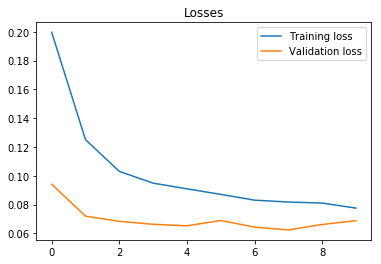

In [37]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")

## Testing the model

The model is trained. We evaluate the model performance with the Area Under the Receiver Operating Characteristic Curve (ROC AUC) on the test set.
scikit-learn's implementation of AUC supports the binary and multilabel indicator format.

Let's use the model to predict the labels for the test set.

In [52]:
model.eval() # disable dropout for deterministic output
with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
    y_preds = []
    batch = 0
    for x_batch, y_batch, batch in generate_batch_data(x_test, y_test, batch_size):
        y_pred = model(x_batch)
        y_preds.extend(y_pred.cpu().numpy().tolist())
    y_preds_np = np.array(y_preds)

The model output 6 values (one for each toxicity threat) between 0 and 1 for each comment.
We can use 0.5 as a threshold to transform all the values greater than 0.5 to toxicity threats, but let's calculate the AUC first.

In [55]:
y_preds_np

array([[4.31922777e-03, 1.02647872e-08, 7.67312944e-04, 4.82944529e-08,
        5.48943179e-04, 1.47456039e-05],
       [1.93794966e-02, 1.65772087e-06, 4.40812251e-03, 3.24758662e-06,
        4.04525641e-03, 1.62638054e-04],
       [1.14875985e-03, 7.16099610e-11, 1.43278172e-04, 7.72443276e-10,
        9.23425468e-05, 1.27330247e-06],
       ...,
       [3.68908630e-03, 4.57207561e-09, 5.53303165e-04, 2.50337173e-08,
        4.26724349e-04, 8.35142146e-06],
       [9.97485360e-04, 4.76052600e-11, 1.12171409e-04, 5.47074053e-10,
        7.51411499e-05, 8.22096808e-07],
       [8.12641159e-02, 3.14069737e-04, 3.06670386e-02, 2.79268977e-04,
        2.92679444e-02, 3.49535886e-03]])

We extract real labels of toxicity threats for the test set. Real labels are binary values.

In [53]:
y_test_np = df_test[target_columns].values

In [60]:
y_test_np[1000:]

array([[1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

The AUC of a model is equal to the probability that the model will rank a randomly chosen positive example higher than a randomly chosen negative example.
The higher the AUC, the better (although it is not that simple, as we will see below).
When AUC is close to 0.5, it means that the model has no label separation capacity whatsoever.
When AUC is close to 0, it means that we need to invert predictions and it should work well :)

Let's calculate the AUC for each label.

In [74]:
auc_scores = roc_auc_score(y_test_np, y_preds_np, average=None)
df_accuracy = pd.DataFrame({"label": target_columns, "auc": auc_scores})
df_accuracy.sort_values('auc')[::-1]

,label,auc
1,severe_toxic,0.966361
4,insult,0.959854
0,toxic,0.954778
3,threat,0.946667
5,identity_hate,0.941165
2,obscene,0.939816


In the table above, we can observe that the model achieves high AUC for every label. 
<b>Note, AUC can be a misleading metric when working with an imbalanced dataset.</b>

### Imbalanced dataset

We say that the dataset is balanced when 50% of labels belong to each class.
The dataset is imbalanced when this ratio is closer to 90% to 10%.
The known problem with models trained on imbalanced datasets is that they report high accuracies. 
Eg. If the model predicts always 0, it can achieve 90% accuracy.

Let's check if we have an imbalanced dataset.

In [82]:
positive_labels = df_train[target_columns].sum().sum()
positive_labels

2201

In [83]:
all_labels = df_train[target_columns].count().sum()
all_labels

60000

In [84]:
positive_labels/all_labels

0.03668333333333333

Only 2201 labels are positive out of 60000 labels. 
The dataset is imbalanced, so the reported accuracy above shouldn't be taken too seriously.

### Sanity check

Let's do a sanity check to see if the model predicts all comments as 0 toxicity threats.

In [102]:
df_test_targets = df_test[target_columns]
df_pred_targets = pd.DataFrame(y_preds_np.round(), columns=target_columns, dtype=int)
df_sanity = df_test_targets.join(df_pred_targets, how='inner', rsuffix='_pred')

In [104]:
df_sanity

,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_pred,severe_toxic_pred,obscene_pred,threat_pred,insult_pred,identity_hate_pred
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,0,0
1998,0,0,0,0,0,0,0,0,0,0,0,0


In [127]:
df_test_targets.sum()

toxic            186
severe_toxic      17
obscene           98
threat             5
insult            96
identity_hate     18
dtype: int64

In [128]:
df_pred_targets.sum()

toxic            91
severe_toxic      0
obscene          43
threat            0
insult           23
identity_hate     0
dtype: int64

We can observe that the model predicted 3 toxicity threats: toxic, obscene and insults, but it never predicted severe_toxic, threat and identify_hate. This doesn't seem great, but at least it didn't mark all comments with zeros.

In [134]:
df_sanity[df_sanity.toxic > 0][['toxic', 'toxic_pred']]

,toxic,toxic_pred
12,1,0
22,1,0
27,1,0
45,1,1
53,1,1
...,...,...
1964,1,1
1965,1,1
1977,1,0
1984,1,0


We see that the model correctly predicted some comments as toxic. 

## Conclusion

We trained a CNN with BERT embeddings for identifying hate speech.
We used a relatively small dataset to make computation faster.
Instead of BERT, we could use Word2Vec, which would speed up the transformation of words to embeddings.
We spend zero time optimizing the model as this is not the purpose of this post.
So reported accuracies shouldn't be taken too seriously.
The more important are outlined pitfalls with imbalanced datasets, AUC and the dropout layer.

Instead of using novel tools like BERT, we could go old school with TD-IDF and Logistic Regression. Would you like to read a post about it? Let me know in the comments below.

## References
[1] Yoon Kim, Convolutional Neural Networks for Sentence Classification (2014), https://arxiv.org/pdf/1408.5882.pdf

[2] Ye Zhang, A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional
Neural Networks for Sentence Classification (2016), https://arxiv.org/pdf/1510.03820.pdf

[3] Jacob Devlin, BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding (2018), https://arxiv.org/abs/1810.04805